# Into the LIME-light  

This notebook is using the LIME package to shed light on the features that most influence individual predictions of a credit default model for small businesses. In a broader sense, it is about the question of how we can become more confident that a model we have trained is actually trustworthy to make sound predictions based on features that we would expect to matter. A model that achieves very high rates of accuracy on a test dataset might still do poorly after deployment if it "learned" correlations that only explain a target variable by accident within the available dataset it has "seen" (e.g., applying for a loan on an even calendar day could correlate with an increased incidence of default within a specific dataset without being true for the wider population). The LIME package offers one way to explore individual model predictions and gain a better understanding of what is happening inside the "black box"

- Link to the original LIME paper: https://www.kdd.org/kdd2016/papers/files/rfp0573-ribeiroA.pdf
- Link to the LIME repository on github: https://github.com/marcotcr/lime

<img src='images/rampenlicht.jpg' width='800' height='600'/>


## Background <a class="tocSkip">

**The problem:** one of the key problems when training ML models is whether we can trust it to make the right predictions under all circumstances. ML models are built and evaluated based on datasets that happen to be available at training time, however, models can find spurious correlations in the dataset which are not real for the wider population or simply make silly mistakes when confronted with data that does not fit the training pattern. It is thus useful to be able to answer the question of what has lead to a certain decision and compare the answer to what human intuition would expect to be a reasonable answer. 

**The method:** LIME (Local Interpretable Model-Agnostic Explanations) is a tool that can be applied to any machine learning model. The idea is to **use a very simple model** (e.g., a linear classifier or regressor) to **approximate the results of a possibly very complex model** across a **very small range** around the feature values of a **specific example.** More specifically, LIME randomly (and very slightly) perturbs the input features of a sample and records the change in model predictions. This creates a local dataset of inputs and outputs which is used to train the "simple" model which mimics the "complex" model across this small range. Since a simple linear regressor is much more readily interpretable than e.g., a deep neural net, we can analyze the behavior of the simple model as an **approximation** of the complex model. The method does not care about the inner workings of the "complex" original model, only about how slight changes in the input affect the output. It is also different from e.g., feature importance analysis (something that XGBoost delivers out of the box) because it answers the question of what most affected a prediction for a **single observation**, rather than which features are the best predictors for the dataset as a whole.

**Limitations of the method:** In the current implementation, only linear models are used to approximate local behavior. It is, however, possible, that a linear model might not be powerful enough to mimic the original model locally (i.e., there are local non-linearities). Also, using a package like LIME does not allow to take shortcuts on thoroughly understanding the data itself (see section 1.3) in order to develop a better intuition for the features that matter and interpret model performance and predictions.

Sources: https://towardsdatascience.com/ai-is-unless-until-it-learns-how-to-explain-itself-7884cca3ba26

## Approach <a class="tocSkip">
    
This notebook consists of two sections: 

1. Building a loan default predictor based on a dataset of small business loans provided by the US Small Business Administration (SBA). After some initial data cleaning and analysis, this notebook uses an out-of-the-box gradient boosted decision tree (implemented with XGBoost) to train a loan default predictor with the following metrics: 
    - Accuracy: 92%
    - Recall: 85%
    - Precision: 91%
2. Analyzing randomly chosen individual model predictions using the LIME package.  

## Other sources

- Understanding LIME: https://towardsdatascience.com/understanding-model-predictions-with-lime-a582fdff3a3b
- Lime explanation by the original authors: https://www.oreilly.com/learning/introduction-to-local-interpretable-model-agnostic-explanations-lime
- Understanding feature importance: https://explained.ai/rf-importance/index.html

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Other-sources" data-toc-modified-id="Other-sources-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Other sources</a></span></li><li><span><a href="#Building-a-loan-default-predictor" data-toc-modified-id="Building-a-loan-default-predictor-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Building a loan default predictor</a></span><ul class="toc-item"><li><span><a href="#Importing-small-business-loan-data" data-toc-modified-id="Importing-small-business-loan-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Importing small business loan data</a></span></li><li><span><a href="#Running-data-preprocessing" data-toc-modified-id="Running-data-preprocessing-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Running data preprocessing</a></span></li><li><span><a href="#Taking-a-closer-look-at-the-data" data-toc-modified-id="Taking-a-closer-look-at-the-data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Taking a closer look at the data</a></span></li><li><span><a href="#Preparing-the-data-for-modeling" data-toc-modified-id="Preparing-the-data-for-modeling-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Preparing the data for modeling</a></span></li><li><span><a href="#Setting-up-the-model" data-toc-modified-id="Setting-up-the-model-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Setting up the model</a></span></li><li><span><a href="#Evaluating-the-model" data-toc-modified-id="Evaluating-the-model-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Evaluating the model</a></span></li><li><span><a href="#Model-feature-importance" data-toc-modified-id="Model-feature-importance-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Model feature importance</a></span></li></ul></li><li><span><a href="#Analyzing-model-predictions-with-LIME" data-toc-modified-id="Analyzing-model-predictions-with-LIME-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analyzing model predictions with LIME</a></span><ul class="toc-item"><li><span><a href="#Understanding-the-LIME-output" data-toc-modified-id="Understanding-the-LIME-output-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Understanding the LIME output</a></span></li><li><span><a href="#A-final-evaluation-of-the-model" data-toc-modified-id="A-final-evaluation-of-the-model-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>A final evaluation of the model</a></span></li></ul></li></ul></div>

In [1]:
# loading packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import sklearn.datasets
import sklearn.ensemble

import xgboost

import lime
import lime.lime_tabular

np.random.seed(1)

import warnings
warnings.filterwarnings("ignore")

## Building a loan default predictor 


### Importing small business loan data 

**Background:** The U.S. Small Business Administration (SBA) was founded in 1953 on the principle of promoting and assisting small enterprises in the U.S. credit market. One way SBA assists these small business enterprises is through a loan guarantee program which is designed to encourage banks to grant loans to small businesses. SBA acts much like an insurance provider to reduce the risk for a bank by taking on some of the risk through guaranteeing a portion of the loan. In the case that a loan goes into default, SBA then covers the amount they guaranteed. 

Source: SBA Overview and History, US Small Business Administration (2015 US Small Business Administration (2015), History retrieved August 22, 2015 from https://www.sba.gov/about-sba/what-we-do/history

**The dataset:** The dataset includes historical data from 1987 through 2014 (899,164 observations). 

Each loan includes the following information:

- **LoanNr_ChkDgt** - Identifier (primary key)
- **Name** - Borrower name
- **City** - Borrower city
- **State** - Borrower state
- **Zip	Text** - Borrower zip code
- **Bank** - Bank name
- **BankState** - Bank state
- **NAICS** - North American industry classification system code
- **ApprovalDate** -	Date/Time	(date SBA commitment was issued)
- **ApprovalFY** - Fiscal year of commitment
- **Term** -	Loan term in months
- **NoEmp** -	Number of business employees of borrower 
- **NewExist** -	1 = Existing business, 2 = New business
- **CreateJob** - Number of jobs created by borrower 
- **RetainedJob** -	Number of jobs retained by borrower 
- **FranchiseCode** - Franchise code, (00000 or 00001) = No franchise
- **UrbanRural** - 1 = Urban, 2 = rural, 0 = undefined
- **RevLineCr** - Revolving line of credit: Y = Yes, N = No
- **LowDoc** - LowDoc Loan Program: Y = Yes, N = No
- **ChgOffDate** - Date/Time	(the date when a loan was declared to be in default)
- **DisbursementDate** - Date/Time	(disbursement date)
- **DisbursementGross** - Amount disbursed (USD)
- **BalanceGross** - Gross amount outstanding (USD)
- **MIS_Status** - Loan status: charged off = CHGOFF, Paid in full = PIF
- **ChgOffPrinGr** - Charged-off amount (USD)
- **GrAppv** - Gross amount of loan approved by bank (USD)
- **SBA_Appv** - SBA's guaranteed amount of approved loan (USD)

Source: https://amstat.tandfonline.com/doi/full/10.1080/10691898.2018.1434342#.XFIxRFxKg2w

In [2]:
# loading data into pandas dataframe 
df = pd.read_csv('C:\\Users\\Philipp Sorgenfrei\\Desktop\\Github\\data\\US_loans\\SBAnational.csv', sep=',')

In [3]:
# taking a look at the first five rows 
df.head()

LoanNr_ChkDgt                           Name          City State    Zip  \
0     1000014003                 ABC HOBBYCRAFT    EVANSVILLE    IN  47711   
1     1000024006    LANDMARK BAR & GRILLE (THE)     NEW PARIS    IN  46526   
2     1000034009          WHITLOCK DDS, TODD M.   BLOOMINGTON    IN  47401   
3     1000044001  BIG BUCKS PAWN & JEWELRY, LLC  BROKEN ARROW    OK  74012   
4     1000054004    ANASTASIA CONFECTIONS, INC.       ORLANDO    FL  32801   

                            Bank BankState   NAICS ApprovalDate ApprovalFY  \
0               FIFTH THIRD BANK        OH  451120    28-Feb-97       1997   
1                1ST SOURCE BANK        IN  722410    28-Feb-97       1997   
2        GRANT COUNTY STATE BANK        IN  621210    28-Feb-97       1997   
3  1ST NATL BK & TR CO OF BROKEN        OK       0    28-Feb-97       1997   
4        FLORIDA BUS. DEVEL CORP        FL       0    28-Feb-97       1997   

       ...       RevLineCr  LowDoc  ChgOffDate  DisbursementDate  \
0      ...               N       Y         NaN         28-Feb-99   
1      ...               N       Y         NaN         31-May-97   
2      ...               N       N         NaN         31-Dec-97   
3      ...               N       Y         NaN         30-Jun-97   
4      ...               N       N         NaN         14-May-97   

   DisbursementGross  BalanceGross  MIS_Status ChgOffPrinGr        GrAppv  \
0        $60,000.00         $0.00        P I F       $0.00    $60,000.00    
1        $40,000.00         $0.00        P I F       $0.00    $40,000.00    
2       $287,000.00         $0.00        P I F       $0.00   $287,000.00    
3        $35,000.00         $0.00        P I F       $0.00    $35,000.00    
4       $229,000.00         $0.00        P I F       $0.00   $229,000.00    

       SBA_Appv  
0   $48,000.00   
1   $32,000.00   
2  $215,250.00   
3   $28,000.00   
4  $229,000.00   

[5 rows x 27 columns]

### Running data preprocessing 

Before taking a closer look at the data, we need to perform **four preprocessing steps:** 
1. **Adjusting datatypes** - converting columns holding numeric or monetary values to a numeric data type (integers or floating point values). The raw data file only holds strings (or more precisely, pandas "objects") 
2. **Creating new data columns** - extracting a binary label for loans in default vs. non-default, a binary label for SBA vs. non-SBA loans, a column holding the percentage share of a loan guaranteed by the SBA, columns holding weekdays and months of loan approval respectively, and a binary label for storing whether a business is a franchise or not 
3. **Cleaning the data** - cleaning some of the categorical data, specifically the columns "RevLineCr" and "LowDoc", which should only contain the binary labels "Y" and "N", as well as the ZIP code column, which should only contain real ZIP codes
4. **Grouping rarely occurring features** - grouping rarely occurring features to prevent the results being influenced by statistically insignificant events

The below function performs these four steps:

In [4]:
def data_preprocess(): 
    
    # load data
    print("loading data..")
    dataframe = pd.read_csv('C:\\Users\\Philipp Sorgenfrei\\Desktop\\Github\\data\\US_loans\\SBAnational.csv', sep=',')
    
    print("converting numeric values..")
    # define columns with meaningful numerical values 
    numerical_columns = ['Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'NewExist']
    currency_columns = ['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']

    # handle NaNs in 'NewExist' column 
    dataframe['NewExist'].fillna(0, inplace= True)
    
    # convert numerical columns to integers 
    dataframe[numerical_columns].astype(int)
    
    # handle exceptions in Fiscal Year column 
    def extractFY(x): 
        if type(x) == str: 
            x = int(x[:4])
        return x
    dataframe['ApprovalFY'] = dataframe['ApprovalFY'].map(lambda x: extractFY(x))
    
    # convert currency columns to floating point numbers 
    dataframe[currency_columns] = (dataframe[currency_columns].replace( '[\$,)]','', regex=True)).astype(float)

    print("creating labels and features..")
    # create binary label for loan write-offs (0 == no charge-off, 1 == charge-off) 
    dataframe.loc[dataframe['ChgOffPrinGr'] == 0, 'binary_label'] = 0
    dataframe.loc[dataframe['ChgOffPrinGr'] > 0, 'binary_label'] = 1
    
    # create binary label or SBA involvement in loans 
    dataframe.loc[dataframe['SBA_Appv'] > 0, 'SBA_marker'] = 1
    dataframe.loc[dataframe['SBA_Appv'] == 0., 'SBA_marker'] = 0
    
    # compute SBA percentage approved 
    dataframe['SBA_share'] = dataframe['SBA_Appv'] / dataframe['GrAppv']

    # extract weekday, and month from approval date
    dataframe["ApprovalDate_DT"] = pd.to_datetime(dataframe["ApprovalDate"], format='%d-%b-%y')
    dataframe["Approval_weekday"] = dataframe["ApprovalDate_DT"].dt.weekday
    dataframe["Approval_month"] = dataframe["ApprovalDate_DT"].dt.month

    # extract franchise yes/no - FranchiseCode (00000, 00001)
    dataframe.loc[(dataframe['FranchiseCode'] == 0) | (dataframe['FranchiseCode'] == 1), 'Franchise_bin'] = 0
    dataframe.loc[dataframe['FranchiseCode'] != 0, 'Franchise_bin'] = 1
    
    print("cleaning data..")
    # clean zip code list 
    # load list of US zip codes: http://federalgovernmentzipcodes.us/  
    zips_df = pd.read_csv('C:\\Users\\Philipp Sorgenfrei\\Desktop\\Github\\data\\US_zip\\US_zip.csv', sep=',')
    
    # extract initial three digits from Zip codes
    zips_df['Zipcode'] = zips_df['Zipcode'].astype(str).str[:3].astype(int) 
    dataframe['Zip'] = dataframe['Zip'].astype(str).str[:3].astype(int) 
    
    dataframe.loc[dataframe['Zip'].isin(zips_df.Zipcode) == False, 'Zip'] = 0
    
    # extract initial two digits from NAICS
    dataframe['NAICS'] = dataframe['NAICS'].astype(str).str[:2].astype(int) 
    
    # replace NAICS code with actual names
    NAICS = [0, 11, 21, 22, 23, 31, 32, 33, 42, 44, 45, 48, 49, 51, 52, 53, 54, 55, 56, 61, 62, 71, 72, 81, 92]
    NAICS_FULL = [
    "No Data",    
    "Agri, Forestry, Fishing",
    "Mining, O&G",
    "Utilities",
    "Construction",
    "Wholesale Trade",
    "Food Manufacturing",
    "Wood Manufacturing",
    "Metal Manufacturing",
    "Retail Wholesale",
    "Retail Trade",
    "Transportation",
    "Postal Service",
    "Information",
    "Finance & Insurance",
    "Real Estate",
    "Prof. Services",
    "Company Mngt",
    "Admin, Support, Waste Mngt",
    "Education",
    "Health Care",
    "Arts, Entertainment",
    "Accommodation, F&B",
    "Other",
    "Public Admin"
    ]

    NAICS_DICT = dict(zip(NAICS, NAICS_FULL))
    dataframe['Industry'] = dataframe.NAICS.map(NAICS_DICT)
    
    # Bin terms 
    dataframe['Term_bin'] = pd.cut(dataframe['Term'].values, 
                                   bins=list(np.arange(-1,max(dataframe['Term'])+11,10)), 
                                   right=True, labels=None, retbins=False, precision = 0)

    # Group features that appear less than 200 times 
    categorical_columns = ['City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'Term'] 
    
    for column in categorical_columns:
        value_list = dataframe[column].value_counts()[dataframe[column].value_counts() > 200].index[:]
        if (column != 'NAISCS') and (column != 'Zip') and (column != 'Term'):
            dataframe.loc[dataframe[column].isin(value_list) == False, column] = 'GROUPED'
        else: 
            dataframe.loc[dataframe[column].isin(value_list) == False, column] = 0
    
    # Make sure RevLine and LowDoc only include Y and N labels  
    dataframe.loc[(dataframe['RevLineCr'] != 'N') & (dataframe['RevLineCr'] != 'Y'), 'RevLineCr'] = 'No data'
    dataframe.loc[(dataframe['LowDoc'] != 'N') & (dataframe['LowDoc'] != 'Y'), 'LowDoc'] = 'No data'
    
    return dataframe

In [5]:
# run preprocessing 
df = data_preprocess()

loading data..
converting numeric values..
creating labels and features..
cleaning data..


The dataset now contains the following columns and respective datatypes:

In [6]:
df.dtypes

LoanNr_ChkDgt                 int64
Name                         object
City                         object
State                        object
Zip                           int32
Bank                         object
BankState                    object
NAICS                         int64
ApprovalDate                 object
ApprovalFY                    int64
Term                          int64
NoEmp                         int64
NewExist                    float64
CreateJob                     int64
RetainedJob                   int64
FranchiseCode                 int64
UrbanRural                    int64
RevLineCr                    object
LowDoc                       object
ChgOffDate                   object
DisbursementDate             object
DisbursementGross           float64
BalanceGross                float64
MIS_Status                   object
ChgOffPrinGr                float64
GrAppv                      float64
SBA_Appv                    float64
binary_label                

### Taking a closer look at the data 

With the processed data ready, we can now take a closer look and develop a better understanding of the data patterns before diving into the model itself.

Running some simple summary statistics, we can observe the following: 
- Overall, the dataset encompasses **USD 173bn in disbursed loans** (across c. 900k individual loans) 
- **All loans in the dataset have received at least some amount of SBA guarantees** 
- Overall, **7% of the total loan amount is charged off** 
- Overall, **18% of all loans are not repaid in full** (i.e., it seems that smaller loans are more likely to default)
- The **average loan is USD 193k**, the smallest loan is USD 200, and the largest loan USD 5.5m 
- The **median loan is USD 90k** 

In [7]:
print('Total value of disbursed loans, in million USD: '+str(df['GrAppv'].sum(axis=0)/1000000))
print('Percentage of loans with SBA guarantees: '+str(df['SBA_marker'].sum(axis=0)/df['SBA_marker'].count()*100))
print('Percentage of overall loan sum charged off: '+str(df['ChgOffPrinGr'].sum(axis=0)/df['GrAppv'].sum(axis=0)*100))
print('Percentage of loans not repaid in full: '+str(df['binary_label'].sum(axis=0)/df['GrAppv'].count()*100))
(df[['GrAppv', 'ChgOffPrinGr']]/1000).describe()

Total value of disbursed loans, in million USD: 173257.192433
Percentage of loans with SBA guarantees: 100.0
Percentage of overall loan sum charged off: 7.007891960211284
Percentage of loans not repaid in full: 18.018070118465594


GrAppv   ChgOffPrinGr
count  899164.000000  899164.000000
mean      192.686976      13.503295
std       283.263391      65.152293
min         0.200000       0.000000
25%        35.000000       0.000000
50%        90.000000       0.000000
75%       225.000000       0.000000
max      5472.000000    3512.596000

A closer look at the underlying frequency distributions of loans and their repayment reveals some interesting findings (each corresponding to one of the below plots in the same order):  

- **The SBA typically guarantees 50% or more of loans:** The Small Business Association seems to prefer guaranteeing 50% of loan amounts, however, we also see spikes at around 80% and even 100% of loan amounts. Other guarantee amounts are 100-1000 times **less** frequent, though also represented in the data.  

- **Loans are approved for up to USD 5m. Charge-offs are most frequent for loans between USD 0-2m:** Most loans are in the range of USD 0-2m where we see a pretty even default rate at around 10%. For loans larger than USD 2m, default seems to be rarer.   

- **The most common default results in a 100% charge-off:** Among the c. 900k loans disbursed, 25k result in a 100% charge-off. All other charge-off values are significantly less frequent. Note; a small number of charge-off fractions are >100% where the charge-off amount exceeds the amount guaranteed by the SBA.

Note: The first two plots below are on a logarithmic scale!

Text(0.5, 1.0, 'Frequency distribution of charge-offs, as a fraction of SBA-guaranteed sum')

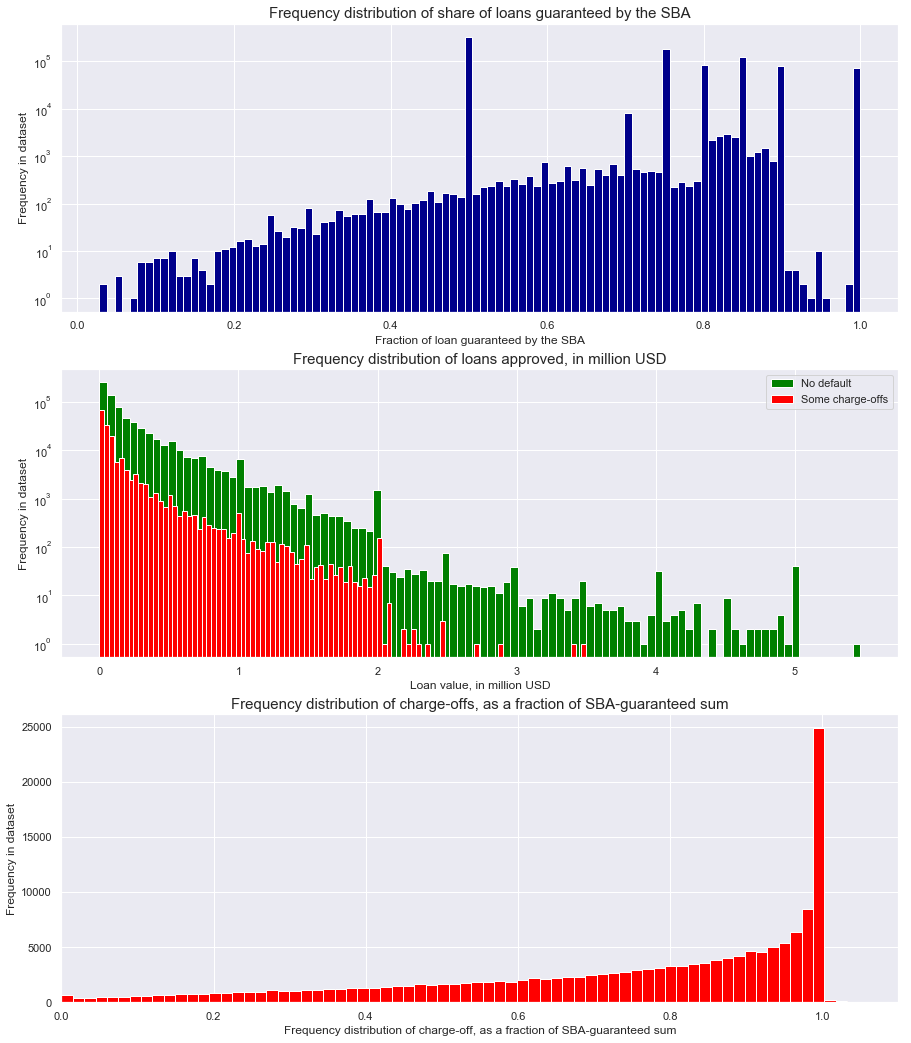

In [8]:
sns.set(rc={'figure.figsize':(15,18)})
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)

# plot 1
ax1.set_yscale('log')

sns.distplot(df['SBA_share'], bins=100, norm_hist = False, kde = False, color='darkblue', ax=ax1, hist_kws=dict(alpha=1))

ax1.set_xlabel("Fraction of loan guaranteed by the SBA")
ax1.set_ylabel("Frequency in dataset")
ax1.set_title("Frequency distribution of share of loans guaranteed by the SBA", {'fontsize': 15})

# plot 2
ax2.set_yscale('log')

sns.distplot(df.GrAppv[df['binary_label']==0]/1000000, bins=100, norm_hist = False, kde = False, label = "No default",
             color = 'green', ax=ax2, hist_kws=dict(alpha=1))
sns.distplot(df.GrAppv[df['binary_label']==1]/1000000, bins=100, norm_hist = False, kde = False, label = "Some charge-offs",
            color = 'red', ax=ax2, hist_kws=dict(alpha=1))

ax2.set_xlabel("Loan value, in million USD")
ax2.set_ylabel("Frequency in dataset")
ax2.set_title("Frequency distribution of loans approved, in million USD", {'fontsize': 15})
ax2.legend()

# plot 3 
df['loss'] = df.ChgOffPrinGr/df.GrAppv

sns.distplot(df.loss[df['binary_label']==1], bins=600, norm_hist = False, kde = False, ax=ax3, label='Charged-off loans',
            color='red', hist_kws=dict(alpha=1))

ax3.set(xlim=(0, 1.1))
ax3.set_xlabel("Frequency distribution of charge-off, as a fraction of SBA-guaranteed sum")
ax3.set_ylabel("Frequency in dataset")
ax3.set_title("Frequency distribution of charge-offs, as a fraction of SBA-guaranteed sum", {'fontsize': 15})

A closer look at the distributions over time generates some further insights:

- **The bulk of the loans were disbursed between 1989 and 2011:** During the 22 years of most lending activity (1989-2011), the amount guaranteed by the SBA decreased as a percentage of the total (though seems to still hover around c. 80%) 
- **Loan charge-offs reached more than 50% during the 60s and 70s and dropped thereafter:** After 30 years of very high charge-off rates, charge-offs dropped to less than 10% in the 1990s spiking briefly around the financial crisis of 2008 to over 20%

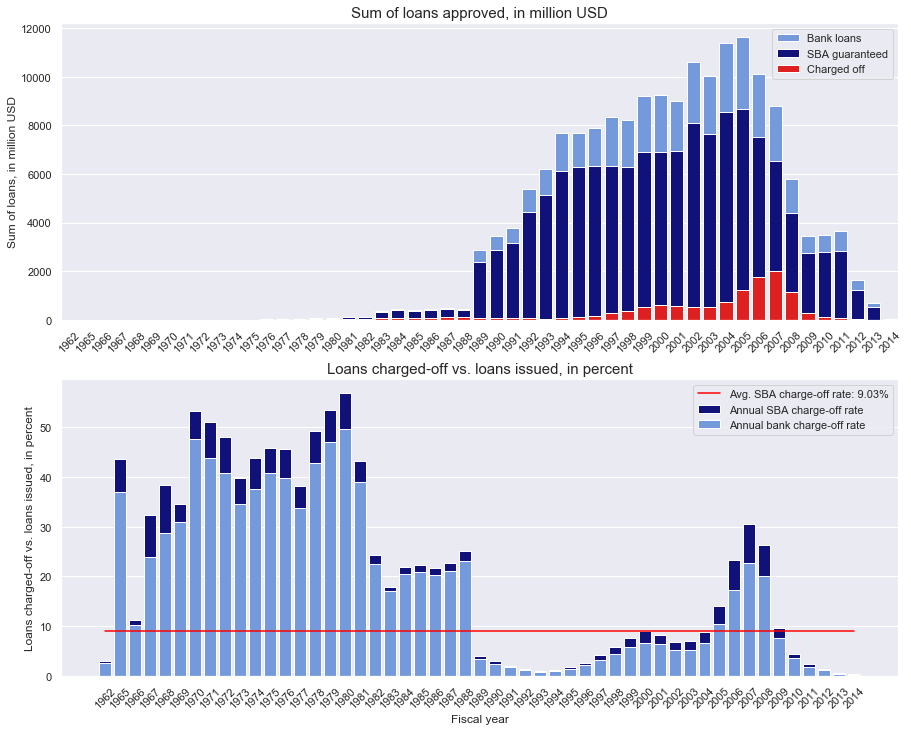

In [9]:
sns.set(rc={'figure.figsize':(15,12)})
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

# plot 1
sns.barplot(x='ApprovalFY', y=(df['GrAppv']/1000000), data=df, ci=None, estimator=sum, color = "cornflowerblue", 
            label="Bank loans", ax=ax1)
sns.barplot(x='ApprovalFY', y=(df['SBA_Appv']/1000000), data=df, ci=None, estimator=sum, color="darkblue", 
            label="SBA guaranteed", ax=ax1)
sns.barplot(x='ApprovalFY', y=(df['ChgOffPrinGr']/1000000), data=df, ci=None, estimator=sum, color="red", 
            label="Charged off", ax=ax1)
ax1.legend(loc="upper right")

# prepare plot 2 - compute average loss per fiscal year for banks and the SBA (loans/charge-offs)
data = pd.DataFrame()
data['year'] =  list(np.unique(df["ApprovalFY"]))
for approver in ['SBA_Appv', 'GrAppv']: 
    loss_rate = []
    for year in np.unique(df["ApprovalFY"]):
        loss = df.ChgOffPrinGr[df["ApprovalFY"] == year]
        loans = df[approver][df["ApprovalFY"] == year]
        loss_rate.append(sum(loss)/sum(loans)*100)
    data[approver+'_rate'] = loss_rate
years = data['year'].unique()

# plot 2
sns.barplot(x='year', y='SBA_Appv_rate', data=data, ci=None, estimator=sum, color = "darkblue", 
            label="Annual SBA charge-off rate", ax=ax2)
sns.barplot(x='year', y='GrAppv_rate', data=data, ci=None, estimator=sum, color = "cornflowerblue", 
            label="Annual bank charge-off rate", ax=ax2)
sns.lineplot(x=np.arange(len(years)), y= [df['ChgOffPrinGr'].sum()/df['SBA_Appv'].sum()*100]*len(years), color = 'red', 
            label='Avg. SBA charge-off rate: '+str(np.round(df['ChgOffPrinGr'].sum()/df['SBA_Appv'].sum()*100, 2))+"%", ax=ax2)

for ax in (ax1, ax2): 
    plt.sca(ax)
    plt.xticks(rotation=45)
    
ax1.set_xlabel(""), ax1.set_ylabel("Sum of loans, in million USD")
ax1.set_title("Sum of loans approved, in million USD", {'fontsize': 15})
ax2.set_xlabel("Fiscal year"), ax2.set_ylabel("Loans charged-off vs. loans issued, in percent")
ax2.set_title("Loans charged-off vs. loans issued, in percent", {'fontsize': 15})

plt.legend()

A closer look at the distributions over categorical variables, reveals some additional interesting patterns:

- **Real Estate and the Financial Industry seem to carry the highest risk:** While most industries in the dataset have a charge-off rate of less than 20% (relative to total loan amount), Real Estate and the Financial Industry are somewhat above 20%. Mining and Agriculture seem to be comparatively safe bets. 
- **Short-term loans are riskier than long-term loans**
- **Loans approved on the weekend are significantly riskier:** While loans approved on a Sunday have a charge-off rate of around 23% (relative to total loan amount), loans approved Monday-Friday have charge of rates of. 13%. 

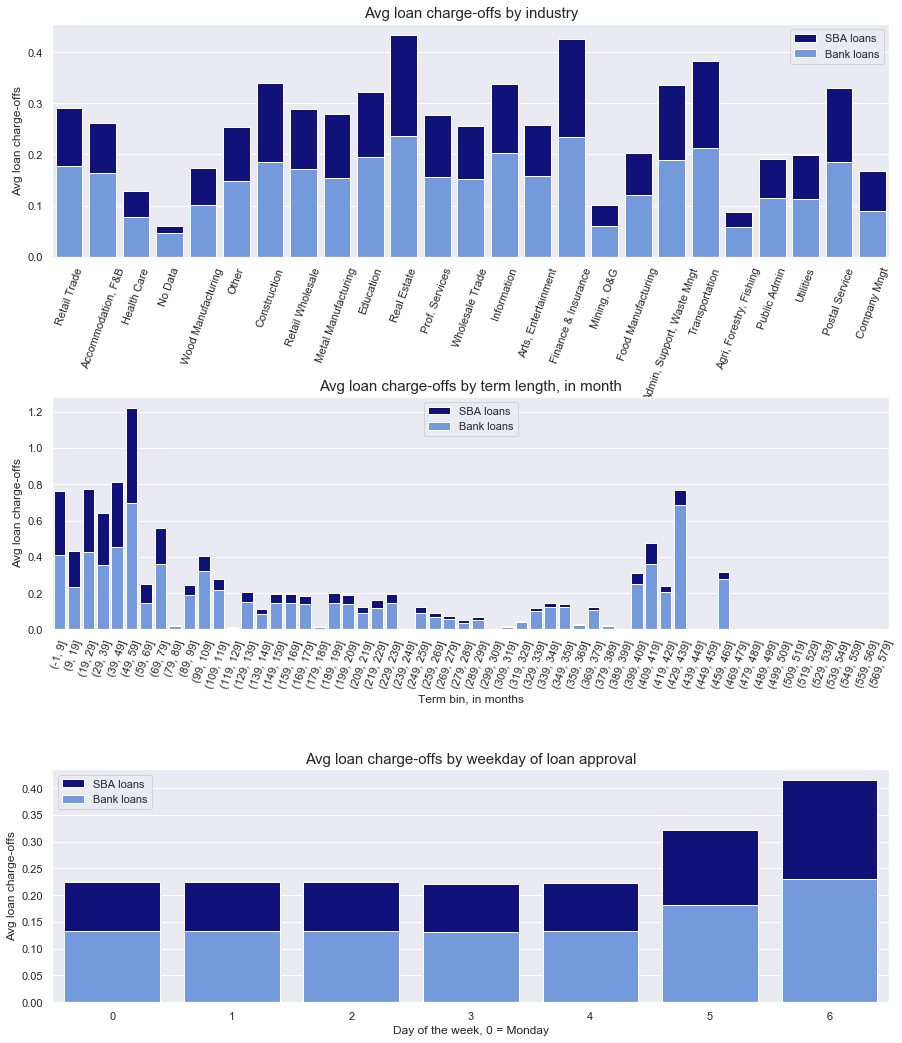

In [10]:
sns.set(rc={'figure.figsize':(15,18)})
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
plt.subplots_adjust(hspace=0.6)

#plot 1 
sns.barplot(x='Industry', y=(df['ChgOffPrinGr']/df['SBA_Appv']), data=df, ci=None, color = "darkblue", 
            label="SBA loans", ax=ax1)
sns.barplot(x='Industry', y=(df['ChgOffPrinGr']/df['GrAppv']), data=df, ci=None, color = "cornflowerblue", 
            label="Bank loans", ax=ax1)
ax1.legend(loc="upper right")

# plot 2
sns.barplot(x='Term_bin', y=(df['ChgOffPrinGr']/df['SBA_Appv']), data=df, ci=None, color = "darkblue", 
            label="SBA loans", ax=ax2)
sns.barplot(x='Term_bin', y=(df['ChgOffPrinGr']/df['GrAppv']), data=df, ci=None, color = "cornflowerblue", 
            label="Bank loans", ax=ax2)
# plot 3
sns.barplot(x=df['Approval_weekday'], y=(df['ChgOffPrinGr']/df['SBA_Appv']), data=df, ci=None, color = "darkblue", 
            label="SBA loans", ax=ax3)
sns.barplot(x=df['Approval_weekday'], y=(df['ChgOffPrinGr']/df['GrAppv']), data=df, ci=None, color = "cornflowerblue", 
           label="Bank loans", ax=ax3)
ax3.legend(loc="upper left")

for ax in (ax1, ax2): 
    plt.sca(ax)
    plt.xticks(rotation=70)
    
ax1.set_xlabel("Industry"), ax1.set_ylabel("Avg loan charge-offs")
ax1.set_title("Avg loan charge-offs by industry", {'fontsize': 15})
ax2.set_xlabel("Term bin, in months"), ax2.set_ylabel("Avg loan charge-offs")
ax2.set_title("Avg loan charge-offs by term length, in month", {'fontsize': 15})
ax3.set_xlabel("Day of the week, 0 = Monday"), ax3.set_ylabel("Avg loan charge-offs")
ax3.set_title("Avg loan charge-offs by weekday of loan approval", {'fontsize': 15})

plt.legend()

### Preparing the data for modeling 

Since the LIME package receives data as numpy arrays, we no longer automatically carry the names of each column (i.e., feature) as was the case while using pandas dataframes. In order to preserve the non-numerical feature identity for the final output and prepare the data for modeling, we need to accomplish the following: 

1. Split off a dataset holding only the labels (i.e., a binary encoding of "no charge-offs" = 0, and "charge-offs" = 1) 
2. Drop columns from the feature dataset that should not be used by the model to predict the labels (e.g., the weekdays charge-offs were registered, the loan number in the dataset, the name of the business, etc.)* 
3. Create separate lists of label and feature names 

*Here is the full list of dropped columns from the feature set:                              
                             
- **LoanNr_ChkDgt** - Identifier – Primary key
- **Name** - Borrower name
- **ChgOffDate** - Date/Time	(the date when a loan is declared to be in default)
- **ApprovalDate** -	Date/Time	(date SBA commitment issued)
- **DisbursementDate** - Date/Time	(disbursement date)
- **MIS_Status** - Loan status charged off = CHGOFF, Paid in full = PIF
- **ChgOffPrinGr** - Charged-off amount (USD)
- **ApprovalDate_DT** - Date of loan approval 
- **SBA_share** - Share of loan guaranteed by the SBA 
- **NAICS** - North American industry classification system code
- **binary_label** - Label to be predicted by the model 
- **Term_bin** - loan term time in months binned to specific ranges 
- **BalanceGross** - Outstanding balance 
- **loss** - whether loss was incurred

In [29]:
def feature_label_split(dataframe):
    
    # extract labels and create list of label names 
    labels_df = dataframe['binary_label']
    labels = np.array(labels_df)
    label_names = np.array(['No default', 'Default'])
    
    # drop ChgOffDate, LoanNr_ChkDgt, Name,  ApprovalDate, DisbursementDate, MIS_Status, ChgOffPrinGr
    features_df = dataframe.drop(labels = ['City', 'ChgOffDate', 'LoanNr_ChkDgt', 'Name', 'ApprovalDate', 'DisbursementDate', 'MIS_Status', 
                             'ChgOffPrinGr', 'ApprovalDate_DT', 'SBA_share', 'binary_label',
                             'SBA_marker', "NAICS", "Term_bin", 'BalanceGross', 'loss'], axis = 1, inplace=False)
    
    # identify categorical features and prepare them for numerical label encoding 
    categorical_columns = ['State', 'Zip', 'Bank', 'BankState', 'RevLineCr', 'LowDoc', 'Approval_weekday', 
                                 'Approval_month', 'Franchise_bin', 'Industry'] 
    features_df[categorical_columns].fillna('No data')
    features_df[categorical_columns] = features_df[categorical_columns].astype('str')
    
    # extract features and list of feature names. Store features in numpy array  
    feature_names = list(features_df.columns)
    feature_data = np.array(features_df)
    
    # create a dictionary of categorical values and replace them with encoded numerical values
    categorical_indeces = [0,1,2,3,12,13,17,18,19,20]
    categorical_names = {}
    for feature in categorical_indeces:
        encoder = sklearn.preprocessing.LabelEncoder()
        encoder.fit(feature_data[:, feature])
        feature_data[:, feature] = encoder.transform(feature_data[:, feature])
        categorical_names[feature] = encoder.classes_  

    feature_data = feature_data.astype(float)
    
    return features_df, feature_names, label_names, categorical_names, categorical_indeces, feature_data, labels 

In [30]:
features_df, feature_names, label_names, categorical_names, categorical_indeces, feature_data, labels = feature_label_split(df)

The categorical feature labels are now stored in a dictionary which captures all existing labels per column (see below). This can be used later to match numbers in the feature numpy array with their actual meaning.

In [31]:
categorical_names

{0: array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
        'GROUPED', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
        'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH',
        'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD',
        'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object),
 1: array(['0', '100', '101', '102', '103', '104', '105', '106', '107', '108',
        '109', '110', '111', '112', '113', '114', '115', '117', '118',
        '119', '120', '121', '122', '123', '124', '125', '126', '127',
        '128', '129', '130', '131', '132', '133', '134', '135', '136',
        '137', '138', '139', '140', '141', '142', '143', '144', '145',
        '146', '147', '148', '149', '150', '151', '152', '153', '154',
        '155', '156', '157', '158', '159', '160', '161', '163', '164',
        '165', '166', '168', '170', '171', '172', '173', '174', '175',
        '176', '177', '178', '180', '181', '182'

The final model input features are now reduced to the following list (with their respective data types) 

In [32]:
features_df.dtypes

State                 object
Zip                   object
Bank                  object
BankState             object
ApprovalFY             int64
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
DisbursementGross    float64
GrAppv               float64
SBA_Appv             float64
Approval_weekday      object
Approval_month        object
Franchise_bin         object
Industry              object
dtype: object

Since XGBoost can only handle numeric values and our feature dataset still holds quite a few non-numeric categories, we will **one-hot encode** them. Each non-numerical feature (such as a bank's name or state) will be encoded in its own column with binary values for 1 = "value is present" and 0 = "value is not present". Using the scikit-learn library below makes this task simple. It also **splits the data into a training set and evaluation set.**  

In [33]:
# create one-hot-encoder instance 
OHencoder = sklearn.preprocessing.OneHotEncoder(categorical_features=categorical_indeces)

# split the data into a train and evaluation set 
np.random.seed(1)
features_train, features_eval, labels_train, labels_eval = sklearn.model_selection.train_test_split(feature_data, 
                                                                                                    labels, 
                                                                                                    train_size=0.90)
# one-hot encode the categorical values 
OHencoder.fit(feature_data)
encoded_train = OHencoder.transform(features_train)
encoded_eval = OHencoder.transform(features_eval)

In [34]:
# check shape of training and evaluation arrays 
print(encoded_train.shape, labels_train.shape)
print(encoded_eval.shape, labels_eval.shape)

(809247, 1367) (809247,)
(89917, 1367) (89917,)


In order to more easily analyze the results of the XGBoost model, it is helpful to carry a list of column names for the (one-hot-encoded) sparse feature array. This can be created from the original non-sparse dataframe in combination with the individual categorical features stored in the "category_name" dictionary:  

In [35]:
"""
Create complete list of column names for sparse feature array 
""" 

# empty list to store feature names
column_names = []

# create dictionary of original feature column names as keys, and a numerical ID (0,1,2,3..) as values 
features_dict = dict(zip(features_df.columns, np.arange(0,len(features_df.columns),1)))

for column in features_dict.keys():
    # check if original column is categorical 
    if features_dict[column] in categorical_names.keys():
        # combine categorical column name of non-sparse array with indiviudal category names 
        for i in categorical_names[features_dict[column]]: 
            column_names.append(column+'_'+str(i))
    else:
        column_names.append(column)

### Setting up the model 

Since the training data has 1,367 columns (due to one-hot encoding the categorical variables), the decision trees of the model will be allowed to be rater shallow (max_depth = 8) to prevent too much overfitting, and quite numerous (n_estimator = 200). 

In [36]:
# define hyperparameters 
hyperparameters = {
    'learning_rate':      0.1,
    'max_depth':          8,  
    'min_child_weight':   1, 
    'gamma':              0.1,
    'subsample':          1,
    'colsample_bytree':   1,
    'colsample_bylevel':  1,
    'reg_alpha':          0,
    'reg_lambda':         1,
    'n_estimators':       200,
    'silent':             True, 
    'n_jobs':             -1
}

In [37]:
# set up training 
XGB_model = xgboost.XGBClassifier(**hyperparameters)

# define evaluation set used during training  
eval_set = [(encoded_train, labels_train), (encoded_eval, labels_eval)]

# run training
XGB_model.fit(encoded_train, labels_train, eval_metric=['logloss', 'error'], 
          eval_set=eval_set, early_stopping_rounds=3, verbose=False)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

### Evaluating the model 

Judging by standard metrics such as Accuracy (96%), Precision (86%), and Recall (92%), the model seems to do fairly well. However, given the extend of overfitting we observe the training plot below, there is certainly room for improvement. The model is also lacking some meaningful data, such as the financial performance of lenders prior to the loan. 


In [38]:
# print metrics
print("Accuracy: "+str(sklearn.metrics.accuracy_score(labels_eval, XGB_model.predict(encoded_eval))))
print("Recall: "+str(sklearn.metrics.recall_score(labels_eval, XGB_model.predict(encoded_eval))))
print("Precision: "+str(sklearn.metrics.precision_score(labels_eval, XGB_model.predict(encoded_eval))))

Accuracy: 0.9593958873183046
Recall: 0.8547950264680537
Precision: 0.9148824033203768


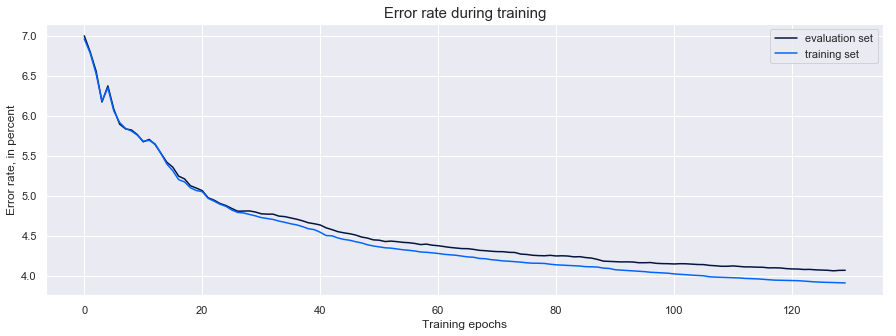

In [39]:
# a look at the training results 
training_results = XGB_model.evals_result()

# retrieve performance metrics. 'validation_0' indicates the training set data (whereas validation_1 == eval set) 
epochs = np.arange(len(training_results['validation_0']['error']))

# plot metrics 
colors = sns.xkcd_palette(["navy", "bright blue"])
sns.set(rc={'figure.figsize':(15,5)}, palette = sns.set_palette(colors, color_codes=False))

fig, ax = plt.subplots()

sns.lineplot(x=epochs, y=np.array(training_results['validation_1']['error'])*100, label="evaluation set")
sns.lineplot(x=epochs, y=np.array(training_results['validation_0']['error'])*100, label="training set")

ax.set_title("Error rate during training", {'fontsize': 15})
ax.set_xlabel("Training epochs"), ax.set_ylabel("Error rate, in percent")

fig.show()

### Model feature importance 

We can take a look at the overall feature importance based on the final trained model. The metric used here is weight, which computes how often a specific feature is used to split two branches of a tree divided by all splits across all trees. A feature importance for "feature x" of 0.1 would mean that "feature x" is used in 10% of all splits. 

Interestingly, the industry of a loan applicant seems to matter most often in the collection of the decision trees. Specifically, the Postal Service industry accounts for more than 20% of the splits while industries in general make up 11 out of the 20 most frequently used features. The size of the business (number of employees) seems to also matter a lot. 

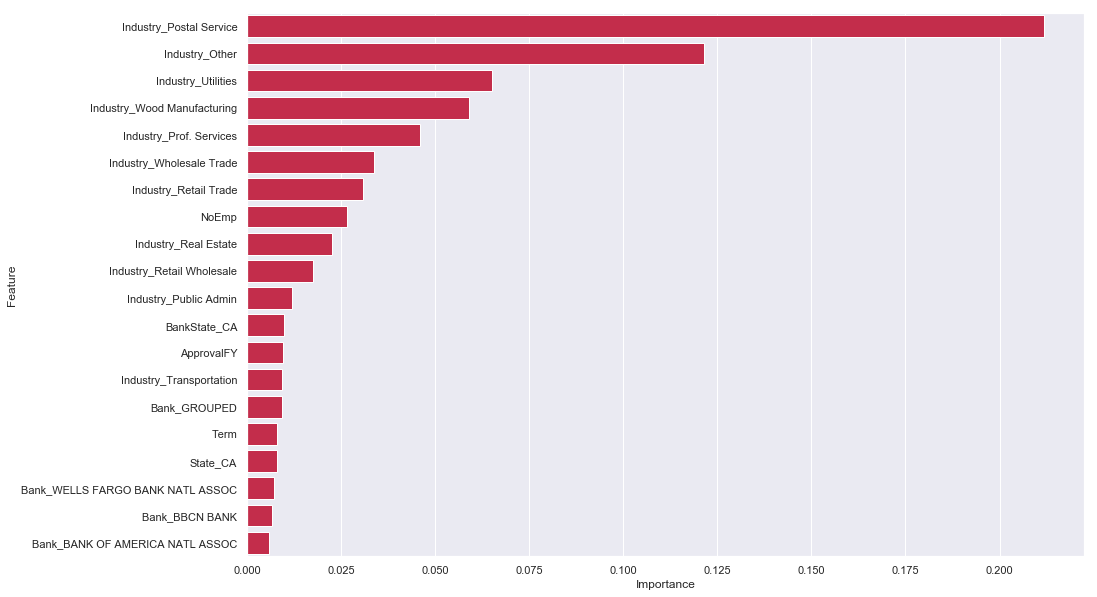

In [40]:
# extract feature importances and recombine columns and their respetive names 
importances = XGB_model.feature_importances_
importances = dict(zip(column_names, importances))
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True, ascending = False)

# plot feature importance 
sns.set(rc={'figure.figsize':(15,10)})
sns.barplot(x=importance_frame[0:20]['Importance'], y=importance_frame[0:20]['Feature'], 
            ci=None, color = "crimson", 
           label="Bank loans")

## Analyzing model predictions with LIME

When analyzing individual model predictions, it will be interesting to compare this to the overall model feature importance shown above. 

In the first step, we need to create a predict function, which uses the XGBoost model we trained earlier to make individual predictions. Next, we create an "explainer" which is a simple linear model trained to predict the predictions of our XGBoost model for a small distance around a particular example.

In [43]:
# define a predict function 
predict_fn = lambda x: XGB_model.predict_proba(OHencoder.transform(x)).astype(float)

# set up explainer 
explainer = lime.lime_tabular.LimeTabularExplainer(features_train, feature_names = feature_names,class_names=label_names,
                                                   categorical_features=categorical_indeces, 
                                                   categorical_names=categorical_names, kernel_width=3)

### Understanding the LIME output 

The below output for randomly chosen examples encompasses three sections (right to left): 
1. Decision-contributing features (setting "show_all=False" below hides all other feature values for that example)
2. Extend to which each contributing feature influences the prediction confidence (loan term time being the most important for most examples below) 
3. Overall prediction confidence (84% confidence that loan will default for the first example below)

**A closer look the first example:**
The largest contributing factor seems to be the loan term time (in months). If the term time was longer than 60 months (5 years), and given the presence of the other features as they are, the model would be 35 percentage points less certain that the loan would not default. We can see the opposite effect in the next column for the impact of the industry of the loan applicant (Professional Services, in this case). The third feature, however, seems to be an artifact of the dataset (i.e., some missing data). Intuitively, the **absence of data** on whether the loan applicant has a revolving line of credit should **not** influence the predicted likelihood for default. This indicates an issue with how the model was trained which should be remedied.   

In [50]:
np.random.seed(1)
for i in [400, 2000, 3000, 11111]:
    exp = explainer.explain_instance(features_eval[i], predict_fn, num_features=5)
    exp.show_in_notebook(show_all=False)
    np.random.seed(1)

### A final evaluation of the model

Overall, the model seems to behave reasonably well. Thinking intuitively about what features should be most important when predicted default, the following could come to mind (not necessarily ordered by importance):

- **Length of loan term** - shorter loans give less time for a small business to succeed 
- **Year of loan approval** - proxy for macroeconomic climate (though this would not be as apparent without the benefit of hindsight) 
- **Number of employees** - proxy for size of company, with smaller start-ups being potentially more risky
- **Industry** - some industries might be riskier than others
- **Number of planned new hires** - proxy for potential business opportunity, more could be better on average 
- **Bank approving the loan** - different banks might have differing loan requirements and risk appetite 
- **ZIP code** - success might be connected to where a business tries to do business  
- **Loan amount** - though we saw already in the data that default rates drop off for loans in excess of USD 2m, this could be expected without this initial insight. A larger loan is likely taken out by a more mature business and thus probably more likely to be repaid 

We can broadly see the above list reflected in the features most influencing individual predictions, though the number of new hires, and the bank approving the loan seems to be less important. 

Comparing what matters most to individual predictions vs. the features that are most frequently used in the decision trees, we see a clear difference. Most notably, loan term time seems very important to all our individual examples while featuring less prominently (though still importantly) in the decision trees.